In [2]:
# Re-import modified modules without restarting the server
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import timeit
import warnings
from time import time
from typing import List

import openai
from dotenv import load_dotenv
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
)

notebook_path = os.path.abspath(get_ipython().starting_dir)
parent_path = os.path.dirname(notebook_path)

sys.path.append(parent_path)
warnings.simplefilter("ignore")

In [4]:
from attribution.api_attribution import APILLMAttributor
from attribution.experiment_logger import ExperimentLogger
from attribution.attribution_metrics import (
    cosine_similarity_attribution,
    token_displacement,
    token_prob_difference,
)
from attribution.token_perturbation import FixedPerturbationStrategy, NthNearestPerturbationStrategy

In [5]:
attributor = APILLMAttributor()
logger = ExperimentLogger()
attributor.compute_attributions(
    "The clock shows 9:47 PM. How many minutes 'til 10?",
    perturbation_strategy=NthNearestPerturbationStrategy(n=-1),
    attribution_strategies=["cosine"],
    logger=logger,
    perturb_word_wise=True,
)
display(logger.df_experiments)
logger.print_sentence_attribution()
logger.print_attribution_matrix(exp_id=1)

,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,The clock shows 9:47 PM. How many minutes 'til...,13 minutes.,nth_nearest (n=-1),True,8.747722


,exp_id,attribution_strategy,perturbation_strategy,perturb_word_wise,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,token_10,token_11,token_12,token_13,token_14,token_15
0,1,cosine,nth_nearest (n=-1),True,The 0.00,clock 0.00,shows 0.00,9 0.15,: 0.15,47 0.15,PM 0.15,. 0.15,How 0.13,many 0.13,minutes 0.13,' 0.11,til 0.11,10 0.11,? 0.11


Attribution matrix for experiment 1 
Attribution Strategy: cosine 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,13 (0),minutes (1),. (2)
The (0),0.000000,-0.000000,0.000000
clock (1),0.000000,-0.000000,0.000000
shows (2),0.000000,-0.000000,0.000000
9 (3),0.688956,0.759586,0.747480
: (4),0.688956,0.759586,0.747480
47 (5),0.688956,0.759586,0.747480
PM (6),0.688956,0.759586,0.701984
. (7),0.688956,0.759586,0.701984
How (8),0.688956,0.759586,0.701984
many (9),0.688956,0.759586,0.701984


In [19]:
attributor = APILLMAttributor()
logger = ExperimentLogger()
for n in [0, 10, 100, 1000, 10000, -1]:
    attributor.compute_attributions(
        "The clock shows 9:47 PM. How many minutes to 10PM?",
        perturbation_strategy=NthNearestPerturbationStrategy(n),
        attribution_strategies=["cosine", "prob_diff", "token_displacement"],
        logger=logger,
        perturb_word_wise=True,
    )

attributor.compute_attributions(
        "The clock shows 9:47 PM. How many minutes to 10PM?",
        perturbation_strategy=FixedPerturbationStrategy(),
        attribution_strategies=["cosine", "prob_diff", "token_displacement"],
        logger=logger,
        perturb_word_wise=True,
    )

display(logger.df_experiments)
logger.print_sentence_attribution()

,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=0),True,9.616563
1,2,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=10),True,11.474948
2,3,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=100),True,7.147294
3,4,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=1000),True,8.664795
4,5,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,nth_nearest (n=10000),True,9.753728
5,6,The clock shows 9:47 PM. How many minutes to 1...,There are 13 minutes left until 10:00 PM.,nth_nearest (n=-1),True,8.575203
6,7,The clock shows 9:47 PM. How many minutes to 1...,13 minutes.,fixed,True,7.040338


,exp_id,attribution_strategy,perturbation_strategy,perturb_word_wise,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,token_10,token_11,token_12,token_13,token_14,token_15
0,1,cosine,nth_nearest (n=0),True,The 0.14,clock 0.14,shows 0.14,9 0.14,: 0.14,47 0.14,PM 0.14,. 0.14,How 0.14,many 0.00,minutes 0.00,to 0.14,10 0.14,PM 0.14,? 0.14
1,1,prob_diff,nth_nearest (n=0),True,The 0.59,clock 0.58,shows 0.59,9 0.60,: 0.60,47 0.60,PM 0.63,. 0.63,How 0.59,many 0.07,minutes 0.09,to 0.59,10 0.58,PM 0.58,? 0.58
2,1,token_displacement,nth_nearest (n=0),True,The 13.33,clock 13.00,shows 13.33,9 13.33,: 13.33,47 13.33,PM 12.67,. 12.67,How 13.33,many 0.00,minutes 0.00,to 13.33,10 13.33,PM 13.33,? 13.33
3,2,cosine,nth_nearest (n=10),True,The 0.14,clock 0.00,shows 0.14,9 0.15,: 0.15,47 0.15,PM 0.14,. 0.14,How 0.14,many 0.00,minutes 0.21,to 0.00,10 0.15,PM 0.15,? 0.15
4,2,prob_diff,nth_nearest (n=10),True,The 0.67,clock 0.06,shows 0.66,9 0.73,: 0.73,47 0.73,PM 0.63,. 0.63,How 0.64,many 0.02,minutes 0.61,to 0.03,10 0.68,PM 0.68,? 0.68
5,2,token_displacement,nth_nearest (n=10),True,The 13.67,clock 0.00,shows 13.00,9 20.00,: 20.00,47 20.00,PM 13.33,. 13.33,How 13.67,many 0.00,minutes 6.33,to 0.00,10 14.00,PM 14.00,? 14.00
6,3,cosine,nth_nearest (n=100),True,The 0.14,clock 0.13,shows 0.00,9 0.12,: 0.12,47 0.12,PM 0.00,. 0.00,How 0.14,many 0.11,minutes 0.11,to 0.00,10 0.00,PM 0.00,? 0.00
7,3,prob_diff,nth_nearest (n=100),True,The 0.68,clock 0.67,shows 0.14,9 0.30,: 0.30,47 0.30,PM 0.02,. 0.02,How 0.71,many 0.22,minutes 0.19,to 0.07,10 0.14,PM 0.14,? 0.14
8,3,token_displacement,nth_nearest (n=100),True,The 13.00,clock 13.67,shows 0.00,9 7.00,: 7.00,47 7.00,PM 0.00,. 0.00,How 13.67,many 6.67,minutes 6.67,to 0.00,10 0.00,PM 0.00,? 0.00
9,4,cosine,nth_nearest (n=1000),True,The 0.14,clock 0.00,shows 0.14,9 0.12,: 0.12,47 0.12,PM 0.14,. 0.14,How 0.14,many 0.11,minutes 0.14,to 0.00,10 0.00,PM 0.00,? 0.00


In [28]:
logger.print_attribution_matrix(exp_id=6, show_debug_cols=True)

Attribution matrix for experiment 6 
Attribution Strategy: cosine 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,There (0),are (1),(2),13 (3),minutes (4),left (5),until (6),(7),10 (8),: (9),00 (10),replacement_token,perturbed_output
The (0),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777019,0.768813,1.000000,1.000000,Streamer,There are 13 minutes left until 10PM.
clock (1),0.688956,0.759586,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,ur,13 minutes
shows (2),0.688956,0.759586,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,etooth,13 minutes
9 (3),0.000000,0.000000,0.540431,0.000000,0.688475,0.688344,0.703812,0.266253,0.819195,0.823731,0.669469,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
: (4),0.000000,0.000000,0.540431,0.000000,0.688475,0.688344,0.703812,0.266253,0.819195,0.823731,0.669469,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
47 (5),0.000000,0.000000,0.540431,0.000000,0.688475,0.688344,0.703812,0.266253,0.819195,0.823731,0.669469,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
PM (6),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777019,0.768813,1.000000,1.000000,TusiHUD,There are 13 minutes left until 10PM.
. (7),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777019,0.768813,1.000000,1.000000,TusiHUD,There are 13 minutes left until 10PM.
How (8),0.688956,0.759586,0.701984,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,erate,13 minutes.
many (9),0.688956,0.759586,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,izu,13 minutes


Attribution matrix for experiment 6 
Attribution Strategy: prob_diff 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,There (0),are (1),(2),13 (3),minutes (4),left (5),until (6),(7),10 (8),: (9),00 (10),PM (11),. (12),replacement_token,perturbed_output
The (0),0.085603,0.000059,0.000527,0.000004,0.000228,0.001671,0.003444,0.000059,0.000000,0.032271,0.999932,0.998296,0.973479,Streamer,There are 13 minutes left until 10PM.
clock (1),0.352243,0.999904,0.999051,0.999972,0.999698,0.559082,0.989993,0.999603,0.999996,0.384833,0.999932,0.998296,0.973479,ur,13 minutes
shows (2),0.322516,0.999904,0.999051,0.999972,0.999698,0.559082,0.989993,0.999603,0.999996,0.384833,0.999932,0.998296,0.973479,etooth,13 minutes
9 (3),0.263713,0.001150,0.000326,0.999972,0.000066,0.558885,0.989993,0.999602,0.999996,0.384833,0.999932,0.998296,0.973479,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
: (4),0.263713,0.001150,0.000326,0.999972,0.000066,0.558885,0.989993,0.999602,0.999996,0.384833,0.999932,0.998296,0.973479,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
47 (5),0.263713,0.001150,0.000326,0.999972,0.000066,0.558885,0.989993,0.999602,0.999996,0.384833,0.999932,0.998296,0.973479,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
PM (6),0.307074,0.000010,0.003843,0.000039,0.000030,0.070354,0.002833,0.000064,0.000000,0.194720,0.999932,0.998296,0.973479,TusiHUD,There are 13 minutes left until 10PM.
. (7),0.307074,0.000010,0.003843,0.000039,0.000030,0.070354,0.002833,0.000064,0.000000,0.194720,0.999932,0.998296,0.973479,TusiHUD,There are 13 minutes left until 10PM.
How (8),0.363518,0.999904,0.999051,0.999972,0.999698,0.559082,0.989993,0.999603,0.999996,0.384833,0.999932,0.998296,0.973479,erate,13 minutes.
many (9),0.433991,0.999904,0.999051,0.999972,0.999698,0.559082,0.989993,0.999603,0.999996,0.384833,0.999932,0.998296,0.973479,izu,13 minutes


Attribution matrix for experiment 6 
Attribution Strategy: token_displacement 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,There (0),are (1),(2),13 (3),minutes (4),left (5),until (6),(7),10 (8),: (9),00 (10),PM (11),. (12),replacement_token,perturbed_output
The (0),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,20.000000,20.000000,Streamer,There are 13 minutes left until 10PM.
clock (1),1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,ur,13 minutes
shows (2),1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,etooth,13 minutes
9 (3),0.000000,0.000000,0.000000,20.000000,0.000000,8.000000,20.000000,4.000000,20.000000,20.000000,20.000000,20.000000,20.000000,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
: (4),0.000000,0.000000,0.000000,20.000000,0.000000,8.000000,20.000000,4.000000,20.000000,20.000000,20.000000,20.000000,20.000000,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
47 (5),0.000000,0.000000,0.000000,20.000000,0.000000,8.000000,20.000000,4.000000,20.000000,20.000000,20.000000,20.000000,20.000000,DERRiHUD full,"There are 60 minutes in an hour, so from 9:00 PM to 10:00 PM is 60 minutes. Therefore, there are 60 minutes until 10:00 PM."
PM (6),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,20.000000,20.000000,20.000000,TusiHUD,There are 13 minutes left until 10PM.
. (7),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,20.000000,20.000000,20.000000,TusiHUD,There are 13 minutes left until 10PM.
How (8),1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,erate,13 minutes.
many (9),1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,izu,13 minutes


In [8]:
logger.df_token_attribution_matrix

,exp_id,attribution_strategy,input_token_pos,output_token_pos,output_token,attr_score,replacement_token,perturbed_output
0,1,cosine,0,0,13,5.960464e-08,The,13 minutes.
1,1,cosine,0,1,minutes,-1.192093e-07,The,13 minutes.
2,1,cosine,0,2,.,0.000000e+00,The,13 minutes.
3,1,prob_diff,0,0,13,8.035906e-03,The,13 minutes.
4,1,prob_diff,0,1,minutes,2.109670e-05,The,13 minutes.
...,...,...,...,...,...,...,...,...
940,7,token_displacement,13,1,minutes,0.000000e+00,,13 minutes to 10:00 PM.
941,7,token_displacement,13,2,.,1.000000e+00,,13 minutes to 10:00 PM.
942,7,token_displacement,14,0,13,0.000000e+00,,13 minutes to 10:00 PM.
943,7,token_displacement,14,1,minutes,0.000000e+00,,13 minutes to 10:00 PM.


In [23]:
relevant_input_ids = [3,5,12]
relevant_output_ids = [0]

perturbation_strategy = ['nth_nearest (n=0)', 'nth_nearest (n=10)', 'nth_nearest (n=100)', 'nth_nearest (n=1000)', 'nth_nearest (n=10000)', 'nth_nearest (n=-1)', 'fixed']
for exp_id in range(1,8):
    for attribution_strategy in ['cosine', 'prob_diff', 'token_displacement']:
        for output_id in relevant_output_ids:
            success = 0
            total = 0
            mean_attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id)]['attr_score'].mean()
            for input_id in relevant_input_ids:
                attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id) & (logger.df_token_attribution_matrix['input_token_pos'] == input_id)]['attr_score'].item()
                if attr_score > mean_attr_score:
                    success += 1
                total += 1

        print(f'Metric score for perturbation_strategy: {perturbation_strategy[exp_id-1]} and attribution_strategy: {attribution_strategy} - {success/total}')

Metric score for perturbation_strategy: nth_nearest (n=0) and attribution_strategy: cosine - 1.0
Metric score for perturbation_strategy: nth_nearest (n=0) and attribution_strategy: prob_diff - 0.6666666666666666
Metric score for perturbation_strategy: nth_nearest (n=0) and attribution_strategy: token_displacement - 1.0
Metric score for perturbation_strategy: nth_nearest (n=10) and attribution_strategy: cosine - 1.0
Metric score for perturbation_strategy: nth_nearest (n=10) and attribution_strategy: prob_diff - 1.0
Metric score for perturbation_strategy: nth_nearest (n=10) and attribution_strategy: token_displacement - 0.6666666666666666
Metric score for perturbation_strategy: nth_nearest (n=100) and attribution_strategy: cosine - 0.6666666666666666
Metric score for perturbation_strategy: nth_nearest (n=100) and attribution_strategy: prob_diff - 0.6666666666666666
Metric score for perturbation_strategy: nth_nearest (n=100) and attribution_strategy: token_displacement - 0.666666666666666

In [57]:
attributor = APILLMAttributor()
logger = ExperimentLogger()
for n in [0, 10, 100, 1000, 10000, -1]:
    attributor.compute_attributions(
        "Jack has 12 teaspoons of sugar. How many tablespoons of sugar does he have?",
        perturbation_strategy=NthNearestPerturbationStrategy(n),
        attribution_strategies=["cosine", "prob_diff", "token_displacement"],
        logger=logger,
        perturb_word_wise=True,
    )

attributor.compute_attributions(
        "Jack has 12 teaspoons of sugar. How many tablespoons of sugar does he have?",
        perturbation_strategy=FixedPerturbationStrategy(),
        attribution_strategies=["cosine", "prob_diff", "token_displacement"],
        logger=logger,
        perturb_word_wise=True,
    )

display(logger.df_experiments)
logger.print_sentence_attribution()

,exp_id,original_input,original_output,perturbation_strategy,perturb_word_wise,duration
0,1,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",nth_nearest (n=0),True,22.573776
1,2,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",nth_nearest (n=10),True,23.924266
2,3,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",nth_nearest (n=100),True,26.890652
3,4,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",nth_nearest (n=1000),True,24.365107
4,5,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",nth_nearest (n=10000),True,24.608838
5,6,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",nth_nearest (n=-1),True,23.335078
6,7,Jack has 12 teaspoons of sugar. How many table...,"There are 3 teaspoons in 1 tablespoon. \n\nSo,...",fixed,True,20.349145


,exp_id,attribution_strategy,perturbation_strategy,perturb_word_wise,token_1,token_2,token_3,token_4,token_5,token_6,token_7,token_8,token_9,token_10,token_11,token_12,token_13,token_14,token_15,token_16
0,1,cosine,nth_nearest (n=0),True,Jack 0.00,has 0.00,12 0.00,teaspoons 0.00,of 0.00,sugar 0.01,. 0.01,How 0.00,many 0.00,tablespoons 0.00,of 0.00,sugar 0.00,does 0.00,he 0.01,have 0.00,? 0.00
1,1,prob_diff,nth_nearest (n=0),True,Jack 0.02,has 0.02,12 0.01,teaspoons 0.02,of 0.02,sugar 0.23,. 0.23,How 0.01,many 0.02,tablespoons 0.02,of 0.02,sugar 0.02,does 0.02,he 0.23,have 0.03,? 0.03
2,1,token_displacement,nth_nearest (n=0),True,Jack 0.00,has 0.00,12 0.00,teaspoons 0.00,of 0.00,sugar 3.57,. 3.57,How 0.00,many 0.00,tablespoons 0.00,of 0.00,sugar 0.00,does 0.00,he 3.46,have 0.00,? 0.00
3,2,cosine,nth_nearest (n=10),True,Jack 0.01,has 0.01,12 0.02,teaspoons 0.08,of 0.01,sugar 0.02,. 0.02,How 0.02,many 0.01,tablespoons 0.07,of 0.01,sugar 0.02,does 0.00,he 0.02,have 0.01,? 0.01
4,2,prob_diff,nth_nearest (n=10),True,Jack 0.33,has 0.32,12 0.35,teaspoons 0.90,of 0.33,sugar 0.90,. 0.90,How 0.42,many 0.82,tablespoons 0.84,of 0.31,sugar 0.53,does 0.02,he 0.41,have 0.33,? 0.33
5,2,token_displacement,nth_nearest (n=10),True,Jack 5.94,has 5.26,12 5.61,teaspoons 16.61,of 5.35,sugar 15.90,. 15.90,How 7.68,many 12.52,tablespoons 17.16,of 5.35,sugar 8.68,does 0.00,he 6.23,have 5.35,? 5.35
6,3,cosine,nth_nearest (n=100),True,Jack 0.01,has 0.02,12 0.02,teaspoons 0.11,of 0.01,sugar 0.02,. 0.02,How 0.00,many 0.00,tablespoons 0.10,of 0.02,sugar 0.02,does 0.02,he 0.02,have 0.03,? 0.03
7,3,prob_diff,nth_nearest (n=100),True,Jack 0.33,has 0.48,12 0.35,teaspoons 0.91,of 0.32,sugar 0.90,. 0.90,How 0.02,many 0.02,tablespoons 0.84,of 0.52,sugar 0.42,does 0.53,he 0.48,have 0.88,? 0.88
8,3,token_displacement,nth_nearest (n=100),True,Jack 5.94,has 7.77,12 5.29,teaspoons 17.84,of 5.29,sugar 15.74,. 15.74,How 0.00,many 0.00,tablespoons 16.32,of 8.77,sugar 7.74,does 8.94,he 7.97,have 15.77,? 15.77
9,4,cosine,nth_nearest (n=1000),True,Jack 0.02,has 0.00,12 0.02,teaspoons 0.04,of 0.01,sugar 0.01,. 0.01,How 0.02,many 0.01,tablespoons 0.07,of 0.02,sugar 0.01,does 0.01,he 0.02,have 0.02,? 0.02


In [58]:
logger.print_attribution_matrix(exp_id=6, show_debug_cols=True)

Attribution matrix for experiment 6 
Attribution Strategy: cosine 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,There (0),are (1),(2),3 (3),teaspoons (4),in (5),(6),1 (7),tablespoon (8),. (9),(10),So (11),", (12)",Jack (13),has (14),(15),12 (16),teaspoons (17),/ (18),(19),3 (20),teaspoons (21),per (22),tablespoon (23),= (24),(25),4 (26),tablespoons (27),replacement_token,perturbed_output
Jack (0),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.783043,0.779808,0.664862,0.741864,0.794346,0.655809,0.822027,0.681302,0.729550,0.723495,0.581232,0.610300,0.412676,1.000000,1.000000,vere,"There are 3 teaspoons in 1 tablespoon. So, Vere has 12 teaspoons / 3 = 4 tablespoons of sugar."
has (1),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.937448,0.664862,0.741864,0.794346,0.655809,0.822027,0.764045,0.768159,0.715805,0.687267,0.756061,0.870664,0.828349,0.845457,aterasu,"There are 3 teaspoons in 1 tablespoon. So, Jackaterasu has 12 teaspoons / 3 teaspoons per tablespoon = 4 tablespoons of sugar."
12 (2),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.752083,0.467724,0.445903,0.724253,0.912066,0.793954,0.772613,0.701114,0.819387,0.693473,0.820869,0.923547,0.742832,0.861659,0.727033,0.592710,0.778383,0.412676,0.832306,0.455691,dylib,"There are 3 teaspoons in 1 tablespoon. Therefore, to convert teaspoons to tablespoons, you would divide the number of teaspoons by 3. So, Jack has dylib / 3 = dylib/3 tablespoons of sugar."
teaspoons (3),0.000000,0.000000,0.469917,0.173723,-0.000000,-0.000000,0.482391,0.412676,0.824027,0.455691,0.672103,0.659853,0.467724,0.721875,0.515306,0.717712,0.790379,0.687043,0.774687,0.887511,0.791721,0.861155,0.684699,0.588128,0.889718,0.669937,0.675527,0.713734,and,"There are 16 tablespoons in 1 cup of sugar. So, Jack has 12 cups of sugar. 12 cups x 16 tablespoons = 192 tablespoons Therefore, Jack has 192 tablespoons of sugar."
of (4),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.727033,0.744895,0.150770,0.638074,0.803535,0.871844,1.000000,1.000000,1.000000,cloneembedreportprint,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12 teaspoons / 3 = 4 tablespoons of sugar."
sugar (5),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.832098,0.666142,0.670854,0.800395,0.781019,0.861659,0.770898,0.615395,1.000000,1.000000,1.000000,1.000000,ArchiHUD,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
. (6),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.832098,0.666142,0.670854,0.800395,0.781019,0.861659,0.770898,0.615395,1.000000,1.000000,1.000000,1.000000,ArchiHUD,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
How (7),0.708782,0.423581,0.158055,0.173723,0.309253,0.807336,0.861155,0.713147,0.672103,0.000000,0.548144,0.682619,0.682482,0.790846,0.790379,0.654153,0.905481,0.706950,0.822027,0.794346,0.731390,0.715805,0.687267,0.756061,1.000000,1.000000,1.000000,1.000000,erate,Jack has 4 tablespoons of sugar. 1 tablespoon = 3 teaspoons 12 teaspoons / 3 = 4 tablespoons
many (8),0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.832098,0.666142,0.670854,0.800395,0.781019,0.861659,0.770898,0.615395,1.000000,1.000000,1.000000,1.000000,izu,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
tablespoons (9),0.708782,0.423581,0.408864,0.000000,0.309253,0.807336,0.861155,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0

Attribution matrix for experiment 6 
Attribution Strategy: prob_diff 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,There (0),are (1),(2),3 (3),teaspoons (4),in (5),(6),1 (7),tablespoon (8),. (9),(10),So (11),", (12)",Jack (13),has (14),(15),12 (16),teaspoons (17),/ (18),(19),3 (20),teaspoons (21),per (22),tablespoon (23),= (24),(25),4 (26),tablespoons (27),of (28),sugar (29),. (30),replacement_token,perturbed_output
Jack (0),0.107927,0.000045,0.000391,0.000010,0.000001,0.000062,0.020052,0.000000,0.000001,0.010067,0.160370,0.143004,0.004546,0.772842,0.000219,0.000297,0.001158,0.006638,0.102601,0.000019,0.000008,0.103523,0.903590,0.999394,0.999875,0.999967,0.999835,0.999977,0.997941,1.000000,0.999940,vere,"There are 3 teaspoons in 1 tablespoon. So, Vere has 12 teaspoons / 3 = 4 tablespoons of sugar."
has (1),0.025365,0.000042,0.002336,0.000342,0.000000,0.000679,0.017087,0.000001,0.000000,0.160984,0.010799,0.188369,0.003433,0.353253,0.993494,0.985439,0.999537,0.503433,0.805457,0.999695,0.999952,0.559952,0.903590,0.999394,0.866650,0.999787,0.999835,0.999977,0.997941,1.000000,0.998807,aterasu,"There are 3 teaspoons in 1 tablespoon. So, Jackaterasu has 12 teaspoons / 3 teaspoons per tablespoon = 4 tablespoons of sugar."
12 (2),0.025090,0.002208,0.024013,0.001144,0.000073,0.001338,0.024770,0.000000,0.000003,0.111888,0.472102,0.467196,0.974867,0.772842,0.998201,0.985438,0.999537,0.503433,0.805457,0.999697,0.999952,0.559893,0.903590,0.999394,0.999875,0.999968,0.999835,0.999977,0.997941,1.000000,0.999940,dylib,"There are 3 teaspoons in 1 tablespoon. Therefore, to convert teaspoons to tablespoons, you would divide the number of teaspoons by 3. So, Jack has dylib / 3 = dylib/3 tablespoons of sugar."
teaspoons (3),0.127841,0.005673,0.117654,0.997256,0.999992,0.015405,0.483207,0.000006,0.999997,0.694404,0.727813,0.467196,0.974867,0.772842,0.998201,0.811285,0.999537,0.503433,0.805457,0.999635,0.999952,0.559952,0.903590,0.999394,0.999875,0.999968,0.999835,0.999977,0.997941,1.000000,0.999940,and,"There are 16 tablespoons in 1 cup of sugar. So, Jack has 12 cups of sugar. 12 cups x 16 tablespoons = 192 tablespoons Therefore, Jack has 192 tablespoons of sugar."
of (4),0.055811,0.000057,0.000122,0.000003,0.000000,0.000150,0.024310,0.000001,0.000000,0.054446,0.063565,0.122779,0.001062,0.012163,0.000036,0.005211,0.000299,0.117103,0.025012,0.000072,0.000015,0.371569,0.903590,0.999394,0.999875,0.999964,0.999835,0.999977,0.997941,1.000000,0.999940,cloneembedreportprint,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12 teaspoons / 3 = 4 tablespoons of sugar."
sugar (5),0.012653,0.000510,0.003666,0.002854,0.000044,0.000513,0.016716,0.000002,0.000006,0.089220,0.219180,0.223691,0.016994,0.061537,0.001894,0.002634,0.006054,0.090029,0.805457,0.999699,0.999952,0.559952,0.903590,0.999394,0.999875,0.999968,0.999835,0.999977,0.997941,1.000000,0.999940,ArchiHUD,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
. (6),0.012653,0.000510,0.003666,0.002854,0.000044,0.000513,0.016716,0.000002,0.000006,0.089220,0.219180,0.223691,0.016994,0.061537,0.001894,0.002634,0.006054,0.090029,0.805457,0.999699,0.999952,0.559952,0.903590,0.999394,0.999875,0.999968,0.999835,0.999977,0.997941,1.000000,0.999940,ArchiHUD,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
How (7),0.420916,0.999872,0.000600,0.999635,0.999996,0.999659,0.965186,0.999999,0.999997,0.783174,0.727813,0.467196,0.974867,0.772842,0.998201,0.985350,0.060775,0.496050,0.002153,0.000409,0.000026,0.156528,0.903590,0.999394,0.999875,0.999968,0.999835,0.999977,0.997941,1.000000,0.999940,erate,Jack has 4 tablespoons of sugar. 1 tablespoon = 3 teaspoons 12 teaspoons / 3 = 4 tablespoons
many (8),0.263731,0.000109,0.000475,0.000098,0.000008,0.000345,0.004240,0.000001,0.000002,0.011031,0.069259,0.108376,0.000257,0.148606,0.000982,0.005399,0.000452,0.227683,0.805457,0.999699,0.999951,0.559952,0.903590,0.999394,0.999875,0.999968,0.999835,0.999977,0.997941,1.000000,0.999940,izu,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
tabl

Attribution matrix for experiment 6 
Attribution Strategy: token_displacement 
Perturbation strategy: nth_nearest (n=-1):
Input Tokens (Rows) vs. Output Tokens (Columns)


,There (0),are (1),(2),3 (3),teaspoons (4),in (5),(6),1 (7),tablespoon (8),. (9),(10),So (11),", (12)",Jack (13),has (14),(15),12 (16),teaspoons (17),/ (18),(19),3 (20),teaspoons (21),per (22),tablespoon (23),= (24),(25),4 (26),tablespoons (27),of (28),sugar (29),. (30),replacement_token,perturbed_output
Jack (0),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,20.000000,20.000000,3.000000,20.000000,20.000000,20.000000,20.000000,20.000000,vere,"There are 3 teaspoons in 1 tablespoon. So, Vere has 12 teaspoons / 3 = 4 tablespoons of sugar."
has (1),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,20.000000,20.000000,20.000000,9.000000,20.000000,20.000000,20.000000,20.000000,1.000000,1.000000,20.000000,20.000000,20.000000,20.000000,1.000000,aterasu,"There are 3 teaspoons in 1 tablespoon. So, Jackaterasu has 12 teaspoons / 3 teaspoons per tablespoon = 4 tablespoons of sugar."
12 (2),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,20.000000,20.000000,20.000000,4.000000,20.000000,20.000000,20.000000,18.000000,20.000000,2.000000,20.000000,20.000000,20.000000,7.000000,20.000000,20.000000,20.000000,20.000000,20.000000,dylib,"There are 3 teaspoons in 1 tablespoon. Therefore, to convert teaspoons to tablespoons, you would divide the number of teaspoons by 3. So, Jack has dylib / 3 = dylib/3 tablespoons of sugar."
teaspoons (3),0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,20.000000,1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,1.000000,20.000000,20.000000,20.000000,13.000000,20.000000,20.000000,20.000000,20.000000,20.000000,8.000000,20.000000,9.000000,20.000000,20.000000,20.000000,and,"There are 16 tablespoons in 1 cup of sugar. So, Jack has 12 cups of sugar. 12 cups x 16 tablespoons = 192 tablespoons Therefore, Jack has 192 tablespoons of sugar."
of (4),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,20.000000,20.000000,4.000000,20.000000,20.000000,20.000000,20.000000,20.000000,cloneembedreportprint,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12 teaspoons / 3 = 4 tablespoons of sugar."
sugar (5),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,5.000000,18.000000,20.000000,20.000000,20.000000,20.000000,14.000000,20.000000,20.000000,20.000000,20.000000,20.000000,ArchiHUD,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
. (6),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,5.000000,18.000000,20.000000,20.000000,20.000000,20.000000,14.000000,20.000000,20.000000,20.000000,20.000000,20.000000,ArchiHUD,"There are 3 teaspoons in 1 tablespoon. So, Jack has 12/3 = 4 tablespoons of sugar."
How (7),1.000000,20.000000,0.000000,3.000000,13.000000,14.000000,1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,erate,Jack has 4 tablespoons of sugar. 1 tablespoon = 3 teaspoons 12 teaspoons / 3 = 4 tablespoons
many (8),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,20.000000,5.000000,18.000000,20.000000,20.000000,20.000000,20.000000,10.000000,20.000000,20.000000,2

In [65]:
relevant_input_ids = [2]
relevant_output_ids = [16, 23]

perturbation_strategy = ['nth_nearest (n=0)', 'nth_nearest (n=10)', 'nth_nearest (n=100)', 'nth_nearest (n=1000)', 'nth_nearest (n=10000)', 'nth_nearest (n=-1)', 'fixed']
for exp_id in range(1,8):
    for attribution_strategy in ['cosine', 'prob_diff', 'token_displacement']:
        for output_id in relevant_output_ids:
            success = 0
            total = 0
            mean_attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id)]['attr_score'].mean()
            for input_id in relevant_input_ids:
                attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id) & (logger.df_token_attribution_matrix['input_token_pos'] == input_id)]['attr_score'].item()
                if attr_score > mean_attr_score:
                    success += 1
                total += 1

        print(f'Metric score for perturbation_strategy: {perturbation_strategy[exp_id-1]} and attribution_strategy: {attribution_strategy} - {success/total}')

ValueError: can only convert an array of size 1 to a Python scalar

In [74]:
input_strings = ['The clock shows 9:47 PM. How many minutes to 10PM?', 'Maria is 37 years old today. How many years till she\'s 50?', 'John has 83 books on his shelf. If he buys 17 more books, how many books will he have in total?', 'The building is 132 meters tall. How many centimeters tall is the building? No explanation', 'The package weighs 8.6 kilograms. How many grams does the package weigh?'] #, 'Jack has 12 teaspoons of sugar. How many tablespoons of sugar does he have?']
relevant_input_ids = [[3,5,12], [2, 13], [2, 11], [3], [2]]
relevant_output_ids = [[0], [3], [11], [0, 2], [16, 26]]

scores = {}

for i, string in enumerate(input_strings):
    print(f'Calculating attributions for {string}')
    attributor = APILLMAttributor()
    logger = ExperimentLogger()
    for n in [0, 10, 100, 1000, 10000, -1]:
        attributor.compute_attributions(
            string,
            perturbation_strategy=NthNearestPerturbationStrategy(n),
            attribution_strategies=["cosine", "prob_diff", "token_displacement"],
            logger=logger,
            perturb_word_wise=True,
        )

    attributor.compute_attributions(
            string,
            perturbation_strategy=FixedPerturbationStrategy(),
            attribution_strategies=["cosine", "prob_diff", "token_displacement"],
            logger=logger,
            perturb_word_wise=True,
        )
    
    input_ids = relevant_input_ids[i]
    output_ids = relevant_output_ids[i]

    perturbation_strategy = ['nth_nearest (n=0)', 'nth_nearest (n=10)', 'nth_nearest (n=100)', 'nth_nearest (n=1000)', 'nth_nearest (n=10000)', 'nth_nearest (n=-1)', 'fixed']
    for exp_id in range(1,8):
        for attribution_strategy in ['cosine', 'prob_diff', 'token_displacement']:
            for output_id in output_ids:
                success = 0
                total = 0
                mean_attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id)]['attr_score'].mean()
                for input_id in input_ids:
                    attr_score = logger.df_token_attribution_matrix[(logger.df_token_attribution_matrix['exp_id'] == exp_id) & (logger.df_token_attribution_matrix['attribution_strategy'] == attribution_strategy) & (logger.df_token_attribution_matrix['output_token_pos'] == output_id) & (logger.df_token_attribution_matrix['input_token_pos'] == input_id)]['attr_score'].item()
                    if attr_score > mean_attr_score:
                        success += 1
                    total += 1

            if f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}' in scores:
                scores[f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}'] += success/total
            else:
                scores[f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}'] = 0
                scores[f'{perturbation_strategy[exp_id-1]}-{attribution_strategy}'] += success/total

        #print(f'Metric score for perturbation_strategy: {perturbation_strategy[exp_id-1]} and attribution_strategy: {attribution_strategy} - {success/total}')

Calculating attributions for The clock shows 9:47 PM. How many minutes to 10PM?
Calculating attributions for Maria is 37 years old today. How many years till she's 50?
Calculating attributions for John has 83 books on his shelf. If he buys 17 more books, how many books will he have in total?
Calculating attributions for The building is 132 meters tall. How many centimeters tall is the building? No explanation
Calculating attributions for The package weighs 8.6 kilograms. How many grams does the package weigh?


In [100]:
len(scores)

21

In [125]:
import pandas as pd

score_df = {'perturbation_strategy': ['-'.join(key.split('-')[0:-1]) for key in scores.keys()], 'attribution_strategy': [key.split('-')[-1] for key in scores.keys()], 'success': list(scores.values())}
score_df = pd.DataFrame(data=score_df, index=[i for i in range(len(scores))])

In [126]:
score_df.iloc[15].perturbation_strategy = 'nth_nearest (n=-1)'

In [127]:
score_df

,perturbation_strategy,attribution_strategy,success
0,nth_nearest (n=0),cosine,0.333333
1,nth_nearest (n=0),prob_diff,2.333333
2,nth_nearest (n=0),token_displacement,0.333333
3,nth_nearest (n=10),cosine,4.000000
4,nth_nearest (n=10),prob_diff,4.500000
5,nth_nearest (n=10),token_displacement,4.166667
6,nth_nearest (n=100),cosine,3.666667
7,nth_nearest (n=100),prob_diff,3.666667
8,nth_nearest (n=100),token_displacement,3.666667
9,nth_nearest (n=1000),cosine,4.166667


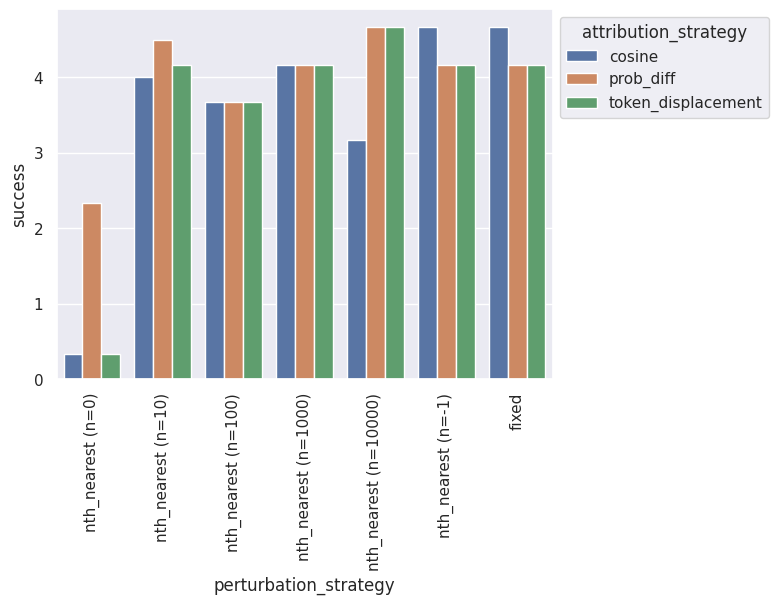

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

g = sns.barplot(data=score_df, x='perturbation_strategy', y='success', hue='attribution_strategy')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

In [90]:
list(scores.values())

[0.3333333333333333,
 2.333333333333333,
 0.3333333333333333,
 4.0,
 4.5,
 4.166666666666666,
 3.6666666666666665,
 3.6666666666666665,
 3.6666666666666665,
 4.166666666666666,
 4.166666666666666,
 4.166666666666666,
 3.1666666666666665,
 4.666666666666666,
 4.666666666666666,
 4.666666666666666,
 4.166666666666666,
 4.166666666666666,
 4.666666666666666,
 4.166666666666666,
 4.166666666666666]